# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
import math
from scipy.stats import norm


In [1]:
! pip install pandas-datareader==0.10.0

     |████████████████████████████████| 109 kB 5.1 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


# Compiling BTC metrics

## Glassnode



### Bitcoin On-chain Columns
#### Price/Market 
* Market Cap
* Realized Cap
* Delta Cap = Realized cap - Average cap

#### Transaction
* Exchange Net flow volume - difference of in volume flowing into exchanges and out of exchanges vs price
* Bitcoin: Number of Transactions per Second or count
Total number of daily transactions

#### Miner
* Miner Revenue - lesser miner revenue could discourage people to mine new cryptocurrency, therefore lower supply which increase cryptocurrency price.
* Percentage mine revenue: fees/minted coins

#### Profit and Loss
* Unrealized Profit/Loss
* Relative Unrealized profit or loss
* Net Unrealized Profit/Loss (NUPL) 
Fear index have a correlation with price

#### Stock index funds or bond interest rate
* SPY

#### Ratios
* Stock-to-flow 
* Stock-to-flow deflection
Is the stock undervalued or overvalued?

#### Indicators (https://cointelegraph.com/magazine/2021/09/03/how-to-prepare-for-end-of-bull-run-part-1-timing)
* Puell Multiple
* MVRV Z-Score

#### Volume
* Entity Balances
* Exchange Net Position Change - All Exchanges
supply held in exchange wallets

#### Unspent/Spent Outputs
* Percent of UTXOs in Profit

In [ ]:
! unzip /content/btc.zip -d /content/dataset

Archive:  /content/btc.zip
   creating: /content/dataset/btc/indicators/
  inflating: /content/dataset/btc/indicators/mvrv-z-score.json  
  inflating: /content/dataset/btc/indicators/puell-multiple.json  
   creating: /content/dataset/btc/miner/
  inflating: /content/dataset/btc/miner/miner-revenue-fees.json  
  inflating: /content/dataset/btc/miner/miner-revenue-total.json  
   creating: /content/dataset/btc/price market/
  inflating: /content/dataset/btc/price market/btc-close-price.json  
  inflating: /content/dataset/btc/price market/delta-cap.json  
  inflating: /content/dataset/btc/price market/market-cap.json  
  inflating: /content/dataset/btc/price market/realized-cap.json  
   creating: /content/dataset/btc/profit loss/
  inflating: /content/dataset/btc/profit loss/net-unrealized-profit-loss-nupl.json  
  inflating: /content/dataset/btc/profit loss/relative-unrealized-loss.json  
  inflating: /content/dataset/btc/profit loss/relative-unrealized-profit.json  
   creating: /con

In [ ]:
from functools import reduce

rootdir = '/content/'

#btc
dfs=[]

#price market
price = pd.read_json(rootdir+'dataset/btc/price market/btc-close-price.json')
price.rename({'v':'close'},axis=1,inplace=True)
dfs.append(price)

deltacap = pd.read_json(rootdir+'dataset/btc/price market/delta-cap.json')
deltacap.rename({'v':'deltacap'},axis=1,inplace=True)
dfs.append(deltacap)

mcap = pd.read_json(rootdir+'dataset/btc/price market/market-cap.json')
mcap.rename({'v':'marketcap'},axis=1,inplace=True)
dfs.append(mcap)

rcap = pd.read_json(rootdir+'dataset/btc/price market/realized-cap.json')
rcap.rename({'v':'realizedcap'},axis=1,inplace=True)
dfs.append(rcap)

#miner
miner_rev_total = pd.read_json(rootdir+'dataset/btc/miner/miner-revenue-total.json')
miner_rev_total.rename({'v':'miner_revenue_total'},axis=1,inplace=True)
dfs.append(miner_rev_total)

miner_rev_fees = pd.read_json(rootdir+'dataset/btc/miner/miner-revenue-fees.json')
miner_rev_fees.rename({'v':'miner_fees_percent'},axis=1,inplace=True)
dfs.append(miner_rev_fees)

#profit loss
nupl = pd.read_json(rootdir+'dataset/btc/profit loss/net-unrealized-profit-loss-nupl.json')
nupl.rename({'v':'nupl'},axis=1,inplace=True)
dfs.append(nupl)

rup = pd.read_json(rootdir+'dataset/btc/profit loss/relative-unrealized-profit.json')
rup.rename({'v':'relative_unrealised_profit'},axis=1,inplace=True)
dfs.append(rup)

rul = pd.read_json(rootdir+'dataset/btc/profit loss/relative-unrealized-loss.json')
rul.rename({'v':'relative_unrealised_loss'},axis=1,inplace=True)
dfs.append(rul)

#transactions
net_flow_vol = pd.read_json(rootdir+'dataset/btc/transaction/exchange-net-flow-volume.json')
net_flow_vol.rename({'v':'net_flow_vol'},axis=1,inplace=True)
dfs.append(net_flow_vol)

tx_rate = pd.read_json(rootdir+'dataset/btc/transaction/transaction-rate.json')
tx_rate.rename({'v':'transaction_rate'},axis=1,inplace=True)
dfs.append(tx_rate)

tx_count = pd.read_json(rootdir+'dataset/btc/transaction/transaction-count.json')
tx_count.rename({'v':'total_transaction'},axis=1,inplace=True)
dfs.append(tx_count)

inhse_vol = pd.read_json(rootdir+'dataset/btc/transaction/in-house-exchange-volume.json')
inhse_vol.rename({'v':'in_house_exchange_volume'},axis=1,inplace=True)
dfs.append(inhse_vol)

#Ratio
rhodl = pd.read_json(rootdir+'dataset/btc/ratio/rhodl-ratio.json')
rhodl.rename({'v':'rhodl_ratio'},axis=1,inplace=True)
dfs.append(rhodl)

stfr = pd.read_json(rootdir+'dataset/btc/ratio/stock-to-flow-ratio.json')
stfr_inner = pd.io.json.json_normalize(stfr.o)
stfr['days_till_halving'] = stfr_inner['daysTillHalving']
stfr['stock_to_flow_ratio'] = stfr_inner['ratio']
del stfr['o']
dfs.append(stfr)

stfrd = pd.read_json(rootdir+'dataset/btc/ratio/stock-to-flow-deflection.json')
stfrd.rename({'v':'stock_to_flow_deflection'},axis=1,inplace=True)
dfs.append(stfrd)

#Indicators
puell = pd.read_json(rootdir+'dataset/btc/indicators/puell-multiple.json')
puell.rename({'v':'puell_multiple'},axis=1,inplace=True)
dfs.append(puell)

mvrv_z = pd.read_json(rootdir+'dataset/btc/indicators/mvrv-z-score.json')
mvrv_z.rename({'v':'mvrv_z_score'},axis=1,inplace=True)
dfs.append(mvrv_z)

#Volume
net_positions = pd.read_json(rootdir+'dataset/btc/volume/exchange-net-position-change.json')
net_positions.rename({'v':'exchange_net_positions_change'},axis=1,inplace=True)
dfs.append(net_positions)

#Unspent spent outputs
utxo = pd.read_json(rootdir+'dataset/btc/unspent spent outputs/percent-utx-os-in-profit.json')
utxo.rename({'v':'percent_utxos_in_profit'},axis=1,inplace=True)
dfs.append(utxo)

df_final = reduce(lambda left,right: pd.merge(left,right,on='t'), dfs)

df_final.rename({'t':'Date'},axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [ ]:
df_final

,Date,close,deltacap,marketcap,realizedcap,miner_revenue_total,miner_fees_percent,nupl,relative_unrealised_profit,relative_unrealised_loss,net_flow_vol,transaction_rate,total_transaction,in_house_exchange_volume,rhodl_ratio,days_till_halving,stock_to_flow_ratio,stock_to_flow_deflection,puell_multiple,mvrv_z_score,exchange_net_positions_change,percent_utxos_in_profit
0,2011-09-16T00:00:00Z,4.811000,1.790593e+07,3.508042e+07,4.460296e+07,5954.968316,0.000834,-0.269386,0.455102,0.724487,0.000000,0.070486,6090,0.000000,36405.899094,439,1.418819,3.390709,0.683785,-0.296380,74.789093,0.116161
1,2011-09-17T00:00:00Z,4.764700,1.788382e+07,3.500338e+07,4.460026e+07,6705.157249,0.000769,-0.281332,0.453971,0.735302,3.000000,0.061574,5320,0.000000,36369.126302,438,1.429329,3.333522,0.766186,-0.305788,69.740065,0.113664
2,2011-09-18T00:00:00Z,5.238233,1.787542e+07,3.551254e+07,4.461236e+07,7905.377962,0.000680,-0.175390,0.458602,0.633992,0.000000,0.067454,5828,0.000000,10320.979929,437,1.441211,3.634606,0.913495,-0.197985,30.148647,0.137569
3,2011-09-19T00:00:00Z,5.462771,1.782855e+07,3.773822e+07,4.459107e+07,6355.927374,0.000933,-0.110628,0.461618,0.572246,0.000000,0.075532,6526,0.000000,9707.107946,436,1.452215,3.796781,0.782018,-0.133952,38.196675,0.148360
4,2011-09-20T00:00:00Z,6.114797,1.782835e+07,4.324777e+07,4.462913e+07,7006.569523,0.000938,0.001172,0.471731,0.470559,0.000000,0.092650,8005,0.000000,9061.306640,435,1.462380,4.181402,0.981353,0.002285,36.377675,0.171815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280,2020-09-08T00:00:00Z,10131.516646,6.916896e+10,1.879044e+11,1.147825e+11,1052.811853,0.079845,0.387441,0.423610,0.036169,-1218.372036,3.848530,332513,215788.516916,1255.550261,1328,16907.225067,0.599242,0.750200,1.130578,-46328.486980,0.831366
3281,2020-09-09T00:00:00Z,10242.347780,6.912000e+10,1.885924e+11,1.147721e+11,1020.445800,0.087409,0.394155,0.427354,0.033199,-6402.890675,3.642535,314715,198613.410220,1218.149708,1327,17047.858960,0.601125,0.725566,1.163849,-51433.836581,0.846510
3282,2020-09-10T00:00:00Z,10363.139040,6.910111e+10,1.913464e+11,1.147925e+11,1097.889664,0.100547,0.401141,0.431491,0.030349,-6675.606661,4.002581,345823,177750.235456,1046.459194,1326,17186.933783,0.602966,0.783411,1.196227,-57160.298374,0.862325
3283,2020-09-11T00:00:00Z,10400.914685,6.905044e+10,1.907593e+11,1.147809e+11,957.667103,0.099374,0.403405,0.432594,0.029189,-4263.930435,3.566956,308185,314398.612055,1027.283195,1325,17306.043343,0.601249,0.683733,1.208088,-53235.466786,0.868686


In [ ]:
df_final['Date'] = pd.to_datetime(df_final['Date'])

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3285 entries, 0 to 3284
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   Date                           3285 non-null   datetime64[ns, UTC]
 1   close                          3285 non-null   float64            
 2   deltacap                       3285 non-null   float64            
 3   marketcap                      3285 non-null   float64            
 4   realizedcap                    3285 non-null   float64            
 5   miner_revenue_total            3285 non-null   float64            
 6   miner_fees_percent             3285 non-null   float64            
 7   nupl                           3285 non-null   float64            
 8   relative_unrealised_profit     3285 non-null   float64            
 9   relative_unrealised_loss       3285 non-null   float64            
 10  net_flow_vol            

## External Data

In [ ]:
from pandas_datareader import data
import pandas_datareader as pdr

panel = data.DataReader(['SPY'],'yahoo',df_final['Date'].min(),df_final['Date'].max())

panel.index= pd.to_datetime(panel.index,utc=True)

# panel.info()
left = df_final
right = panel['Close']['SPY']

df_final = pd.merge(left,right,on='Date')
df_final

,Date,close,deltacap,marketcap,realizedcap,miner_revenue_total,miner_fees_percent,nupl,relative_unrealised_profit,relative_unrealised_loss,net_flow_vol,transaction_rate,total_transaction,in_house_exchange_volume,rhodl_ratio,days_till_halving,stock_to_flow_ratio,stock_to_flow_deflection,puell_multiple,mvrv_z_score,exchange_net_positions_change,percent_utxos_in_profit,SPY
0,2011-09-16 00:00:00+00:00,4.811000,1.790593e+07,3.508042e+07,4.460296e+07,5954.968316,0.000834,-0.269386,0.455102,0.724487,0.000000,0.070486,6090,0.000000,36405.899094,439,1.418819,3.390709,0.683785,-0.296380,74.789093,0.116161,121.519997
1,2011-09-19 00:00:00+00:00,5.462771,1.782855e+07,3.773822e+07,4.459107e+07,6355.927374,0.000933,-0.110628,0.461618,0.572246,0.000000,0.075532,6526,0.000000,9707.107946,436,1.452215,3.796781,0.782018,-0.133952,38.196675,0.148360,120.309998
2,2011-09-20 00:00:00+00:00,6.114797,1.782835e+07,4.324777e+07,4.462913e+07,7006.569523,0.000938,0.001172,0.471731,0.470559,0.000000,0.092650,8005,0.000000,9061.306640,435,1.462380,4.181402,0.981353,0.002285,36.377675,0.171815,120.169998
3,2011-09-21 00:00:00+00:00,5.660936,1.783093e+07,4.206669e+07,4.466705e+07,7305.176050,0.000709,-0.072696,0.461405,0.534101,-2.359200,0.087245,7538,1.097109,9019.748440,434,1.470041,3.850870,0.993476,-0.100491,34.489884,0.153137,116.629997
4,2011-09-22 00:00:00+00:00,5.473564,1.776414e+07,4.044050e+07,4.463167e+07,7403.784086,0.000511,-0.121610,0.458133,0.579743,8.020000,0.069340,5991,0.000000,8904.867436,433,1.477814,3.706122,0.956951,-0.139906,28.358884,0.142457,112.860001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,2020-09-04 00:00:00+00:00,10511.813881,6.946709e+10,1.926044e+11,1.149259e+11,999.213460,0.155586,0.408739,0.437477,0.028738,5093.556384,3.450822,298151,337996.565937,1642.824295,1332,16493.187262,0.637343,0.664499,1.239988,-60528.531459,0.864046,342.570007
2258,2020-09-08 00:00:00+00:00,10131.516646,6.916896e+10,1.879044e+11,1.147825e+11,1052.811853,0.079845,0.387441,0.423610,0.036169,-1218.372036,3.848530,332513,215788.516916,1255.550261,1328,16907.225067,0.599242,0.750200,1.130578,-46328.486980,0.831366,333.209991
2259,2020-09-09 00:00:00+00:00,10242.347780,6.912000e+10,1.885924e+11,1.147721e+11,1020.445800,0.087409,0.394155,0.427354,0.033199,-6402.890675,3.642535,314715,198613.410220,1218.149708,1327,17047.858960,0.601125,0.725566,1.163849,-51433.836581,0.846510,339.790009
2260,2020-09-10 00:00:00+00:00,10363.139040,6.910111e+10,1.913464e+11,1.147925e+11,1097.889664,0.100547,0.401141,0.431491,0.030349,-6675.606661,4.002581,345823,177750.235456,1046.459194,1326,17186.933783,0.602966,0.783411,1.196227,-57160.298374,0.862325,333.890015


In [ ]:
df_final.to_csv('btc_metrics_raw.csv')

# EDA

## Reload dataframe

In [ ]:
df = pd.read_csv('btc_metrics_raw.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.set_index('Date',inplace=True)

## Dataset Summary (Sean)

In [ ]:
df.head(3)

,close,deltacap,marketcap,realizedcap,miner_revenue_total,miner_fees_percent,nupl,relative_unrealised_profit,relative_unrealised_loss,net_flow_vol,transaction_rate,total_transaction,in_house_exchange_volume,rhodl_ratio,days_till_halving,stock_to_flow_ratio,stock_to_flow_deflection,puell_multiple,mvrv_z_score,exchange_net_positions_change,percent_utxos_in_profit,SPY
Date,,,,,,,,,,,,,,,,,,,,,,
2011-09-16 00:00:00+00:00,4.811000,1.790593e+07,3.508042e+07,4.460296e+07,5954.968316,0.000834,-0.269386,0.455102,0.724487,0.0,0.070486,6090,0.0,36405.899094,439,1.418819,3.390709,0.683785,-0.296380,74.789093,0.116161,121.519997
2011-09-19 00:00:00+00:00,5.462771,1.782855e+07,3.773822e+07,4.459107e+07,6355.927374,0.000933,-0.110628,0.461618,0.572246,0.0,0.075532,6526,0.0,9707.107946,436,1.452215,3.796781,0.782018,-0.133952,38.196675,0.148360,120.309998
2011-09-20 00:00:00+00:00,6.114797,1.782835e+07,4.324777e+07,4.462913e+07,7006.569523,0.000938,0.001172,0.471731,0.470559,0.0,0.092650,8005,0.0,9061.306640,435,1.462380,4.181402,0.981353,0.002285,36.377675,0.171815,120.169998


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2262 entries, 2011-09-16 00:00:00+00:00 to 2020-09-11 00:00:00+00:00
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   close                          2262 non-null   float64
 1   deltacap                       2262 non-null   float64
 2   marketcap                      2262 non-null   float64
 3   realizedcap                    2262 non-null   float64
 4   miner_revenue_total            2262 non-null   float64
 5   miner_fees_percent             2262 non-null   float64
 6   nupl                           2262 non-null   float64
 7   relative_unrealised_profit     2262 non-null   float64
 8   relative_unrealised_loss       2262 non-null   float64
 9   net_flow_vol                   2262 non-null   float64
 10  transaction_rate               2262 non-null   float64
 11  total_transaction              2262 non-null   int64  
 12  in_house

In [ ]:
df.isnull().sum()

close                            0
deltacap                         0
marketcap                        0
realizedcap                      0
miner_revenue_total              0
miner_fees_percent               0
nupl                             0
relative_unrealised_profit       0
relative_unrealised_loss         0
net_flow_vol                     0
transaction_rate                 0
total_transaction                0
in_house_exchange_volume         0
rhodl_ratio                      0
days_till_halving                0
stock_to_flow_ratio              0
stock_to_flow_deflection         0
puell_multiple                   0
mvrv_z_score                     0
exchange_net_positions_change    0
percent_utxos_in_profit          0
SPY                              0
dtype: int64

In [ ]:
# Date range
print("Date range: from",df.index.min(),"to",df.index.max())

Date range: from 2011-09-16 00:00:00+00:00 to 2020-09-11 00:00:00+00:00


## Summary Statistics (Sean)

In [ ]:
df.describe()

,close,deltacap,marketcap,realizedcap,miner_revenue_total,miner_fees_percent,nupl,relative_unrealised_profit,relative_unrealised_loss,net_flow_vol,transaction_rate,total_transaction,in_house_exchange_volume,rhodl_ratio,days_till_halving,stock_to_flow_ratio,stock_to_flow_deflection,puell_multiple,mvrv_z_score,exchange_net_positions_change,percent_utxos_in_profit,SPY
count,2262.000000,2.262000e+03,2.262000e+03,2.262000e+03,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2.262000e+03,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000
mean,2986.883109,2.188043e+10,5.169182e+10,3.207193e+10,3468.117388,0.031246,0.287125,0.474118,0.186992,892.144184,2.071173,178949.343501,1.818546e+05,8119.695711,647.375332,2943.212460,1.587770,1.427681,1.409572,25816.414163,0.701750,219.400566
std,3893.881721,2.866130e+10,6.885258e+10,4.139705e+10,1862.404524,0.049639,0.322831,0.110648,0.249038,8071.309284,1.381741,119382.379750,2.399180e+05,18841.330003,420.550178,3682.681089,1.404265,1.101623,1.757350,52272.096056,0.228664,56.784771
min,2.051027,1.134847e+07,1.712380e+07,3.805939e+07,812.832697,0.000334,-1.556947,0.298256,0.000000,-69789.426736,0.052477,4534.000000,0.000000e+00,93.414668,1.000000,1.418819,0.403787,0.283478,-0.830057,-141930.378788,0.081815,109.930000
25%,227.271806,1.802930e+09,3.201842e+09,3.091518e+09,1960.978255,0.004051,0.142812,0.394939,0.024529,-1893.644291,0.734514,63462.000000,3.064073e+03,535.355230,275.000000,111.895187,0.826209,0.720232,0.262185,-322.979416,0.552930,179.734997
50%,608.133039,2.865072e+09,8.382543e+09,4.718180e+09,3364.720998,0.011587,0.369361,0.453023,0.086768,312.244701,2.292164,198043.000000,1.061068e+05,1790.315658,605.000000,419.380348,1.074149,1.109856,1.051727,13032.366660,0.753799,210.039993
75%,6372.125508,5.574235e+10,1.106236e+11,8.176636e+10,4237.245574,0.033944,0.489283,0.542577,0.263679,3142.044520,3.334476,288098.750000,2.750883e+05,6990.146055,1013.000000,5873.656612,1.653927,1.762708,1.733519,43167.997660,0.879512,270.057495
max,19007.009332,7.706836e+10,3.152863e+11,1.149841e+11,9104.485005,0.435698,0.838999,0.838999,1.956250,96773.489188,5.676609,490459.000000,1.854388e+06,219470.016332,1448.000000,17306.043343,9.801527,10.167732,12.547296,247987.930335,1.000000,357.700012


Preliminary statistics for quartile range. Due to non normal distribution of price and returns, normal IQR outlier rules may not apply:

In [ ]:
df_quantiles = df.quantile([0.25,0.5,0.75])

iqr =  df_quantiles.loc[0.75] - df_quantiles.loc[0.25]

df_quantiles['iqr'] = iqr

df_quantiles

,close,deltacap,marketcap,realizedcap,miner_revenue_total,miner_fees_percent,nupl,relative_unrealised_profit,relative_unrealised_loss,net_flow_vol,transaction_rate,total_transaction,in_house_exchange_volume,rhodl_ratio,days_till_halving,stock_to_flow_ratio,stock_to_flow_deflection,puell_multiple,mvrv_z_score,exchange_net_positions_change,percent_utxos_in_profit,SPY,iqr
0.25,227.271806,1.802930e+09,3.201842e+09,3.091518e+09,1960.978255,0.004051,0.142812,0.394939,0.024529,-1893.644291,0.734514,63462.00,3064.072906,535.355230,275.0,111.895187,0.826209,0.720232,0.262185,-322.979416,0.552930,179.734997,NaN
0.50,608.133039,2.865072e+09,8.382543e+09,4.718180e+09,3364.720998,0.011587,0.369361,0.453023,0.086768,312.244701,2.292164,198043.00,106106.795356,1790.315658,605.0,419.380348,1.074149,1.109856,1.051727,13032.366660,0.753799,210.039993,NaN
0.75,6372.125508,5.574235e+10,1.106236e+11,8.176636e+10,4237.245574,0.033944,0.489283,0.542577,0.263679,3142.044520,3.334476,288098.75,275088.278311,6990.146055,1013.0,5873.656612,1.653927,1.762708,1.733519,43167.997660,0.879512,270.057495,NaN


## Univariate analysis (Sean)

### Histogram

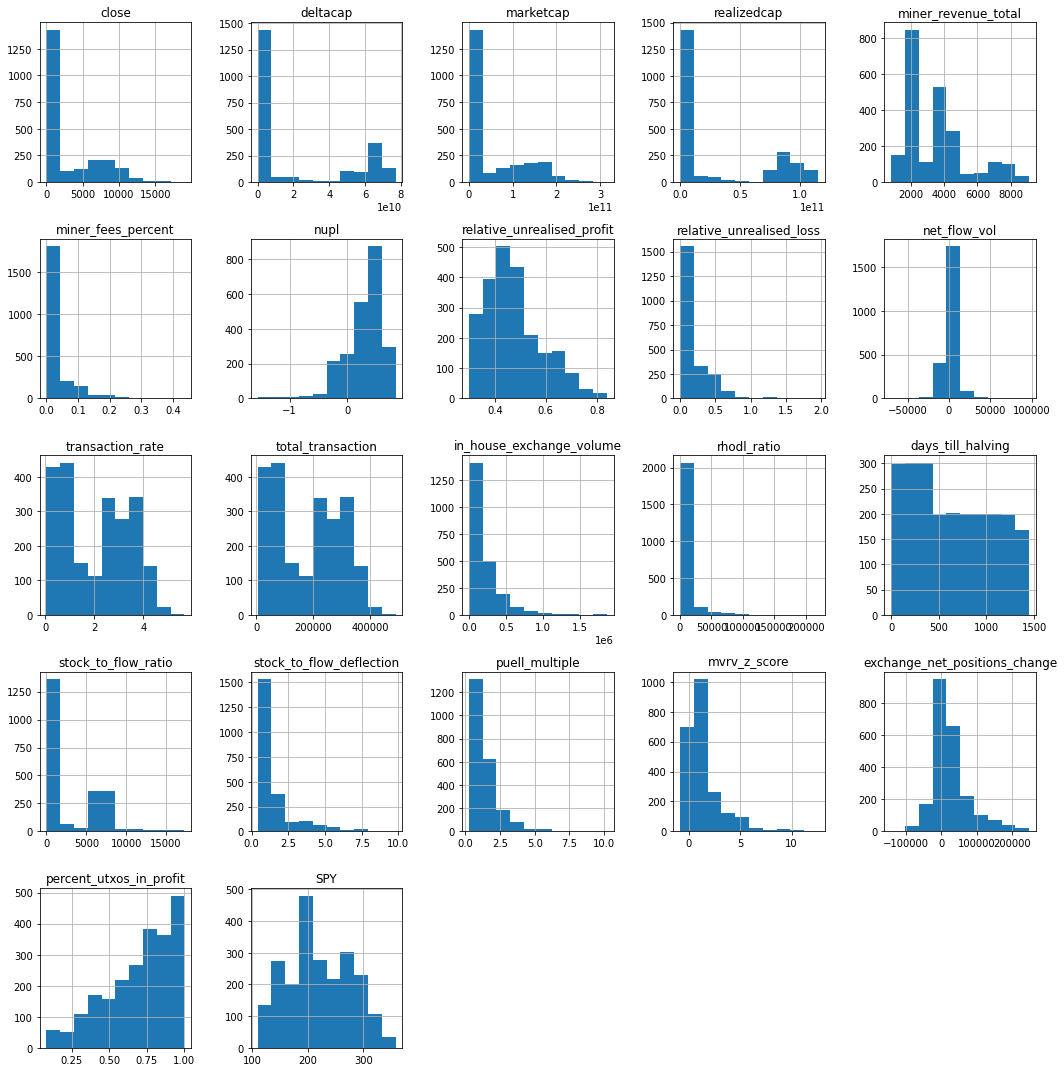

In [ ]:
df.hist(figsize=(15,15))
plt.tight_layout()
plt.show()

### Boxplot

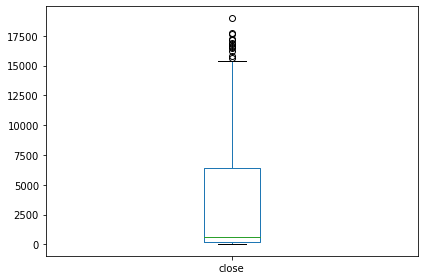

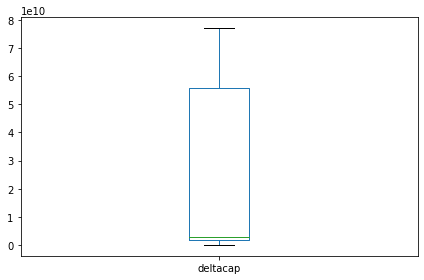

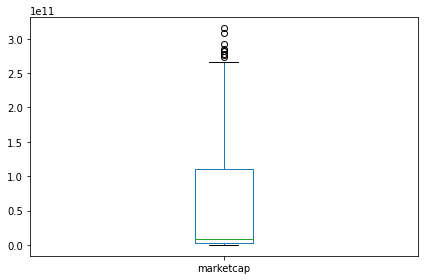

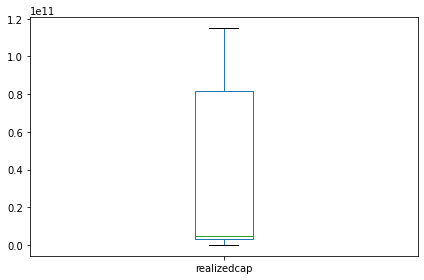

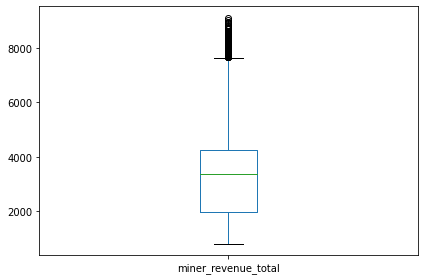

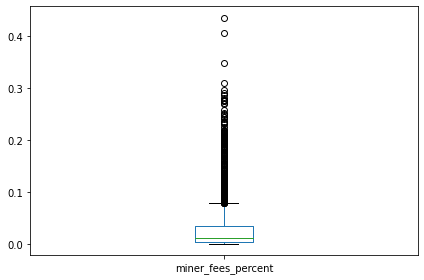

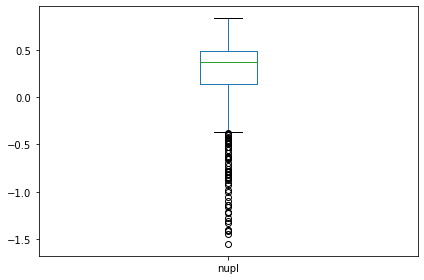

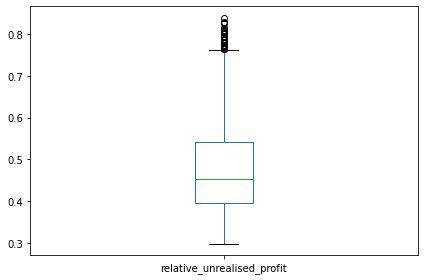

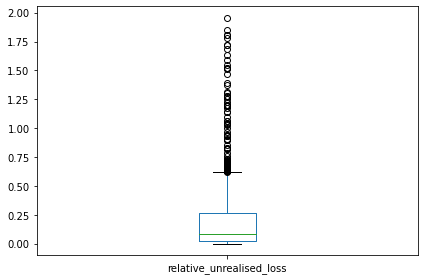

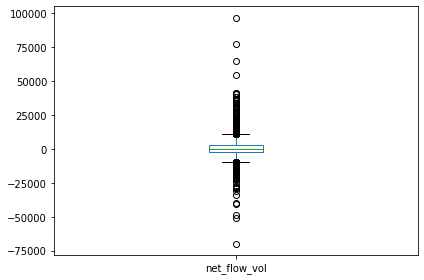

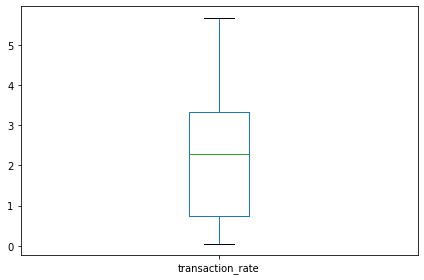

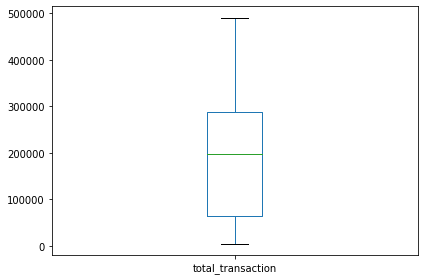

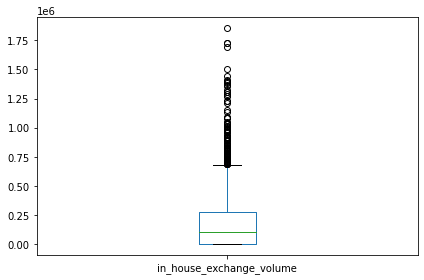

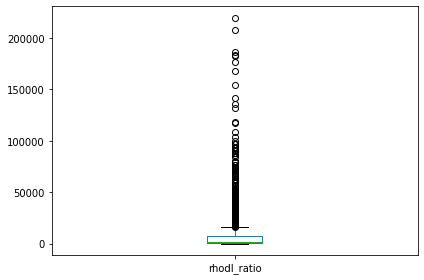

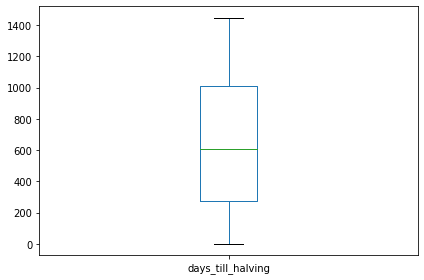

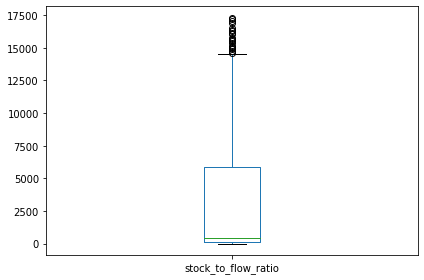

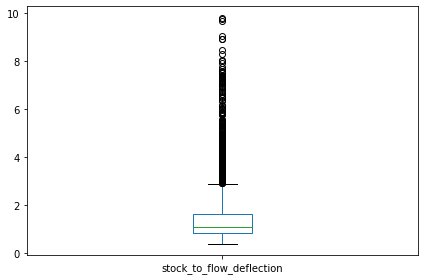

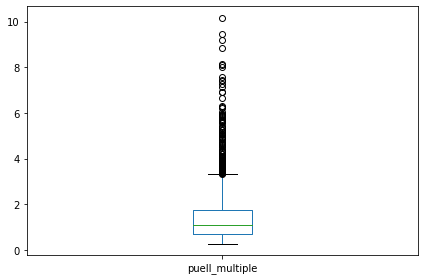

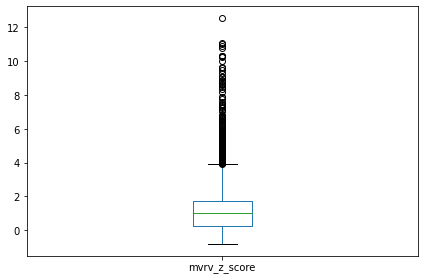

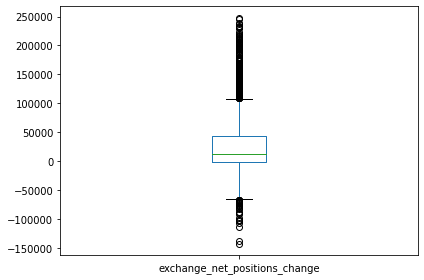

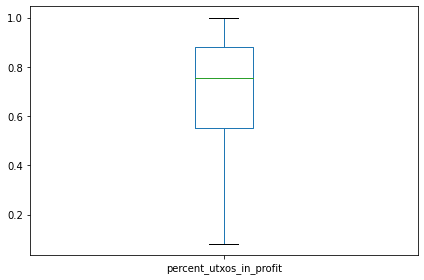

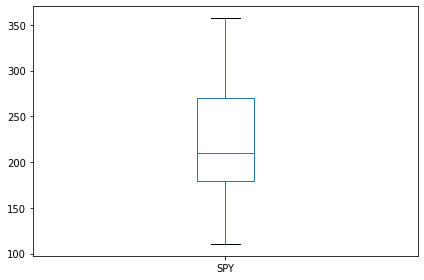

In [ ]:
numeric_cols = df.select_dtypes(include=['float','int'])
for col in numeric_cols:
  df[col].plot.box()
  plt.tight_layout()
  plt.show()

### Moving Averages (Sky)

NameError: ignored

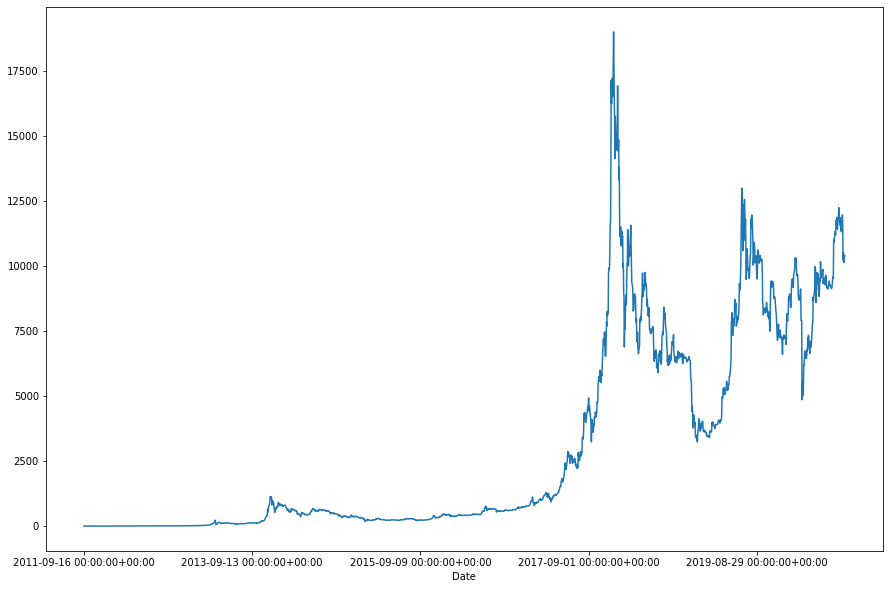

In [ ]:
ax = df['close'].plot(figsize=(15,10))
ma_long_close = close.rolling(window=100).mean()
ax.plot(ma_long_close, label='100 days rolling')

ma_long_close = close.rolling(window=50).mean()
ax.plot(ma_long_close, label='50 days rolling')

ma_long_close = close.rolling(window=20).mean()
ax.plot(ma_long_close, label='20 days rolling')

ax.set_title('BTC Price with 20/50/100MA')
ax.legend()

## Bivariate analysis (Edwin)
<br>1.Correlation between 2 numeric variables 
  <br>a.Pearson's R
<br>2.
Scatter plot between 2 numeric variables


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#df = df_final
columns=len(df. columns)
columns+=1

In [ ]:
sns.pairplot(df[[
"close",                 
# "marketcap",
"realizedcap",
"miner_revenue_total",
"net_flow_vol",
"transaction_rate",
"total_transaction",
"in_house_exchange_volume",
"stock_to_flow_ratio",
"puell_multiple",
"SPY"
]])

In [ ]:
def correlation(close,variable):
    for columns in variable:
        output=df[['close', columns]]
        fig, axes = plt.subplots(7,3,figsize=(20,20))
        axes = axes.flatten()
        scatter= output.plot(kind='scatter', x='close', y=columns)
        corr= output.corr(method='pearson', min_periods=1)
        print(corr.tail(1))
        scatter


In [ ]:
corr = df.corr(method='pearson', min_periods=1)

fig, ax = plt.subplots(figsize=(20,20))
#sns.heatmap(corr, cmap="Reds",ax=ax)
sns.heatmap(cor, annot = True, ax = ax, cmap="YlGnBu")

In [ ]:
list_all = []
close=df['close']
for i in range(3,columns-1):
    column = df. columns[i]
    list_all.append(column)
    
correlation(close,list_all)

## Returns and Volatility analysis (Casper,Edwin,Naomi)

### Return series (Edwin)


In [ ]:
Returnseries_close=df['close']
Returnseries_close = (1 + Returnseries_close.pct_change()).cumprod()-1
Returnseries_close

In [ ]:
ax = Returnseries_close.plot(figsize=(15,10))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

### Annualised Volatility (Casper)

In [2]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy.stats as stat
from scipy.stats import norm

%matplotlib inline

from tabulate import tabulate

def calc_annualised_HV (tickers, start_date):
    end_date = "2020-09-11"
    panel_data = data.DataReader(tickers, 'yahoo', start_date, end_date)
    close = panel_data['Close']
    print(close)
    for columns in close:
        #20day HV
        crypto_20d = close[columns].tail(20)
        crypto_20d_hv = np.sqrt(np.log(crypto_20d / crypto_20d.shift(1)).var()) * np.sqrt(252)

        #3 months HV
        crypto_3m = close[columns].loc['2020-6-11':'2020-09-11']
        crypto_3m_hv = np.sqrt(np.log(crypto_3m / crypto_3m.shift(1)).var()) * np.sqrt(252)

        #1 year HV
        crypto_1y = close[columns].loc['2019-09-11':'2020-09-11']
        crypto_1y_hv = np.sqrt(np.log(crypto_1y / crypto_1y.shift(1)).var()) * np.sqrt(252)

        #All 4 years HV
        crypto_all_hv = np.sqrt(np.log(close[columns] / close[columns].shift(1)).var()) * np.sqrt(252)

        print(tabulate([['20d', crypto_20d_hv],['3m', crypto_3m_hv],['1y', crypto_1y_hv],['all', crypto_all_hv]],
                       headers=['Time', columns + ' Historical Volatility']))

### Rolling Volatility (Casper)

In [3]:
def rolling_HV (tickers, start_date, window_list):
    end_date = "2020-09-11"
    panel_data = data.DataReader(tickers, 'yahoo', start_date, end_date)
    close_1y = panel_data['Close'].loc['2019-09-11':'2020-09-11']
    for window_n in window_list:
        cchv = np.sqrt(252) * pd.DataFrame.rolling(np.log(close_1y / close_1y.shift(1)),window=window_n).std()
        cchv.plot(figsize=(16,9))
        plt.legend(loc='lower left')
        plt.title('Close to Close Historical Volatility for ' + str(window_n) + 'days')
        plt.show()

###  Sharpe ratio (Casper)

In [4]:
def calc_sharpe_ratio (tickers, start_date, rate):
    end_date = "2020-09-11"
    panel_data = data.DataReader(tickers, 'yahoo', start_date, end_date)
    closes_1y = panel_data[['Close', 'Adj Close']].loc['2019-09-11':'2020-09-11']
    
    returns_ts = closes_1y['Adj Close'].pct_change().dropna()
    avg_daily_ret = returns_ts.mean()

    returns_ts['RiskFree_Rate'] = rate/252
    avg_rf_ret = returns_ts['RiskFree_Rate'].mean()
    
    for columns in tickers:
        returns_ts['Excess_ret_' + columns] = returns_ts[columns] - returns_ts['RiskFree_Rate']
        sharpe = ((avg_daily_ret[columns] - avg_rf_ret) /returns_ts['Excess_ret_' + columns].std())*np.sqrt(252)
        print("Sharpe Ratio " + columns + " :\n", sharpe.round(3))

In [5]:
# tickers = ['BTC-USD']
# start_date = "2016-09-15"
tickers = ['BTC-USD', 'LTC-USD', 'ETH-USD']
start_date = "2019-09-15"

In [6]:
calc_annualised_HV(tickers, start_date)

Symbols          BTC-USD    LTC-USD     ETH-USD
Date                                           
2019-09-15  10347.712891  70.315178  189.789124
2019-09-16  10276.793945  72.573112  197.113174
2019-09-17  10241.272461  74.221230  208.608749
2019-09-18  10198.248047  77.969131  211.393036
2019-09-19  10266.415039  77.059624  221.280853
...                  ...        ...         ...
2020-09-08  10131.516602  47.383801  337.602112
2020-09-09  10242.347656  47.897697  351.110016
2020-09-10  10363.138672  48.716854  368.101898
2020-09-11  10400.915039  49.089752  374.695587
2020-09-12  10442.170898  50.817154  387.183105

[363 rows x 3 columns]
Time      BTC-USD Historical Volatility
------  -------------------------------
20d                            0.513193
3m                             0.379191
1y                             0.641486
all                            0.640606
Time      LTC-USD Historical Volatility
------  -------------------------------
20d                            0

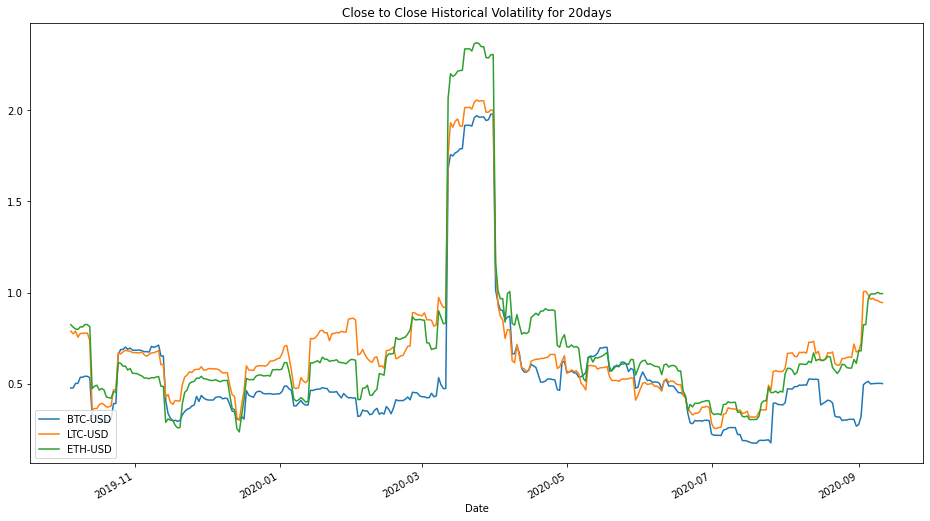

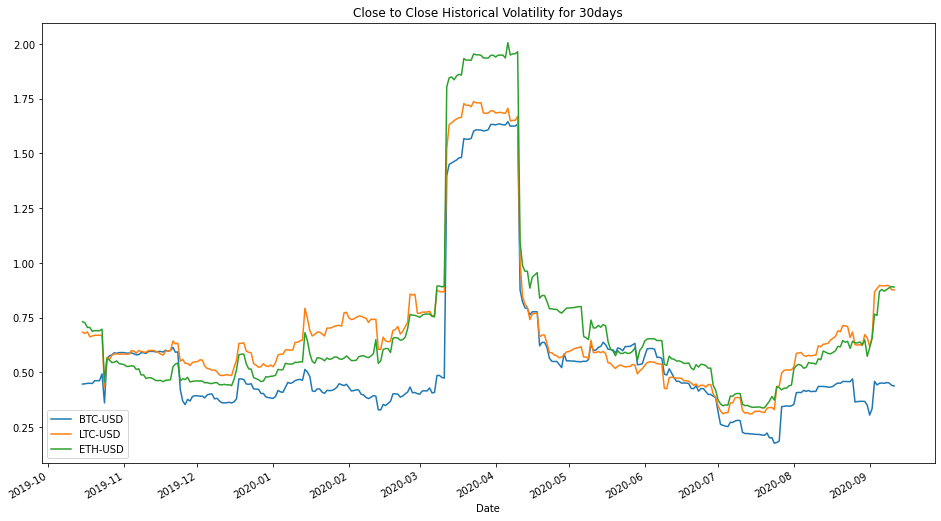

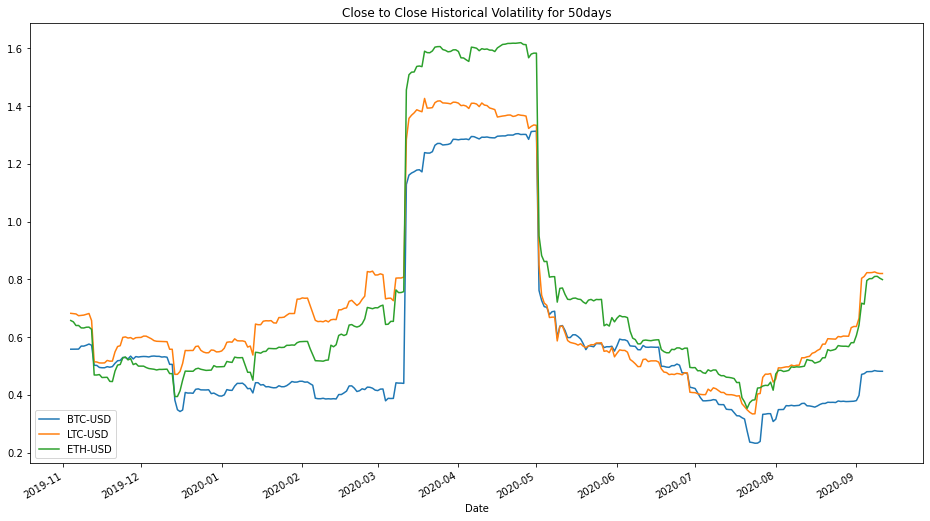

In [7]:
rolling_HV(tickers, start_date, [20, 30, 50])

In [8]:
calc_sharpe_ratio(tickers, start_date, 0.01)

Sharpe Ratio BTC-USD :
 0.314
Sharpe Ratio LTC-USD :
 0.045
Sharpe Ratio ETH-USD :
 1.018


### Annualised Returns (Naomi)

In [ ]:
Returnseries_close
period = 10  # number of years
annualised_returns = ((1 + Returnseries_close.tail(1))**(1/period) - 1) * 100
annualised_returns

NameError: ignored

### Distribution of daily returns (Naomi)

In [ ]:
pct_returns = df['close'].pct_change()
mean = pct_returns.mean()
median = pct_returns.median()
std_dev = pct_returns.std()
print("Mean---\n", mean)
print("Median---\n", median)
print("Standard deviation---\n", std_dev)

In [ ]:
# create points for normal distribution
x=np.linspace(mean-3*std_dev, mean + 3*std_dev, 100)

# plot distribution of btc pct_returns with normal distribution
plt.figure(figsize=(16,5))
plt.hist(pct_returns, bins=60, edgecolor='black');
plt.plot(x, norm.pdf(x,mean,std_dev),color="r")
plt.title('Distribution of Percentage Returns')

In [ ]:
pct_returns.dropna(inplace= True)

import statsmodels.api as sm
sm.qqplot(pct_returns, line = 's')
plt.title('Q-Q Plot')
plt.show()

In [ ]:
print(pct_returns.skew())
print(pct_returns.kurtosis())

## Cross correlation (Sky, Sean)

### On chain cross correlation (Sean)

In [ ]:
def cross_corr(target,var,shifts):
  cross_corrs = []
  for s in shifts:
    cross_corrs.append(target.corr(var.shift(s)))
  return cross_corrs

In [ ]:
shift_min = -62
shift_max = 62
shifts = range(shift_min,shift_max+1) #in days

targets = ['close']

for target in targets:

  numeric_cols = list(df.select_dtypes(include=['float','int']).columns)
  numeric_cols.remove(target)

  fig, axes = plt.subplots(7,3,figsize=(20,20))
  axes = axes.flatten()
  for variable , ax in zip(numeric_cols,axes):
    corrs = cross_corr(df[target],df[variable],shifts)

    ax.plot(shifts,corrs)
    ax.set_xlabel('Day shift')
    ax.set_ylabel('Correlation')
    ax.set_title(f'Cross Corr: {target} , {variable}')

plt.tight_layout()